In [56]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [57]:
images = glob('train_cancer/*/*.jpg')
len(images)


270

In [58]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()


,filepath,label
0,train_cancer/malignant/63.jpg,malignant
1,train_cancer/malignant/189.jpg,malignant
2,train_cancer/malignant/77.jpg,malignant
3,train_cancer/malignant/162.jpg,malignant
4,train_cancer/malignant/176.jpg,malignant


In [59]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()


,filepath,label,label_bin
0,train_cancer/malignant/63.jpg,malignant,1
1,train_cancer/malignant/189.jpg,malignant,1
2,train_cancer/malignant/77.jpg,malignant,1
3,train_cancer/malignant/162.jpg,malignant,1
4,train_cancer/malignant/176.jpg,malignant,1


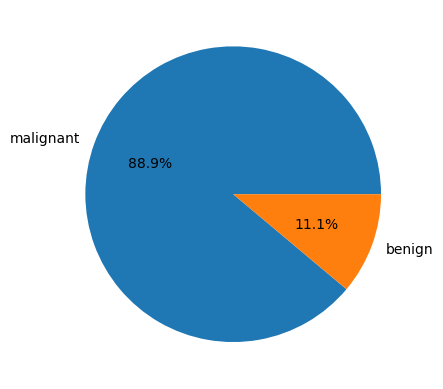

In [60]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()


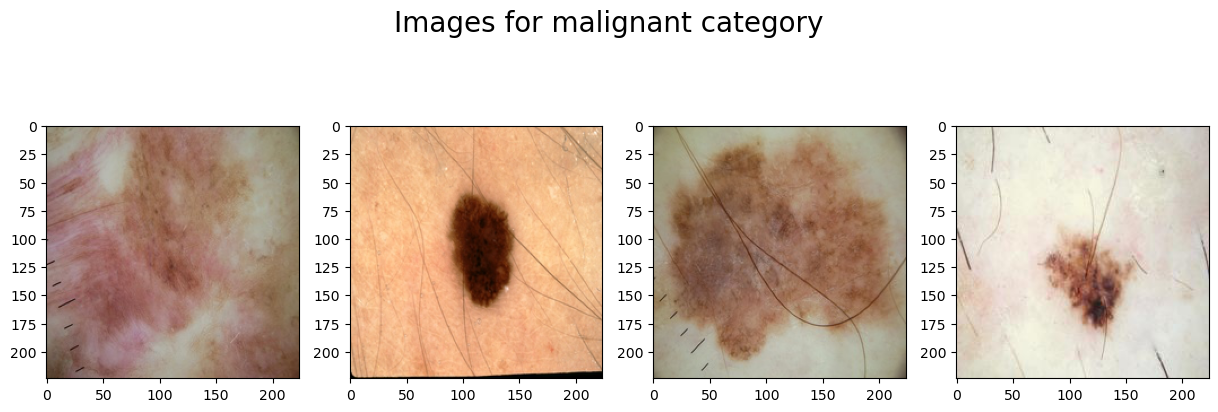

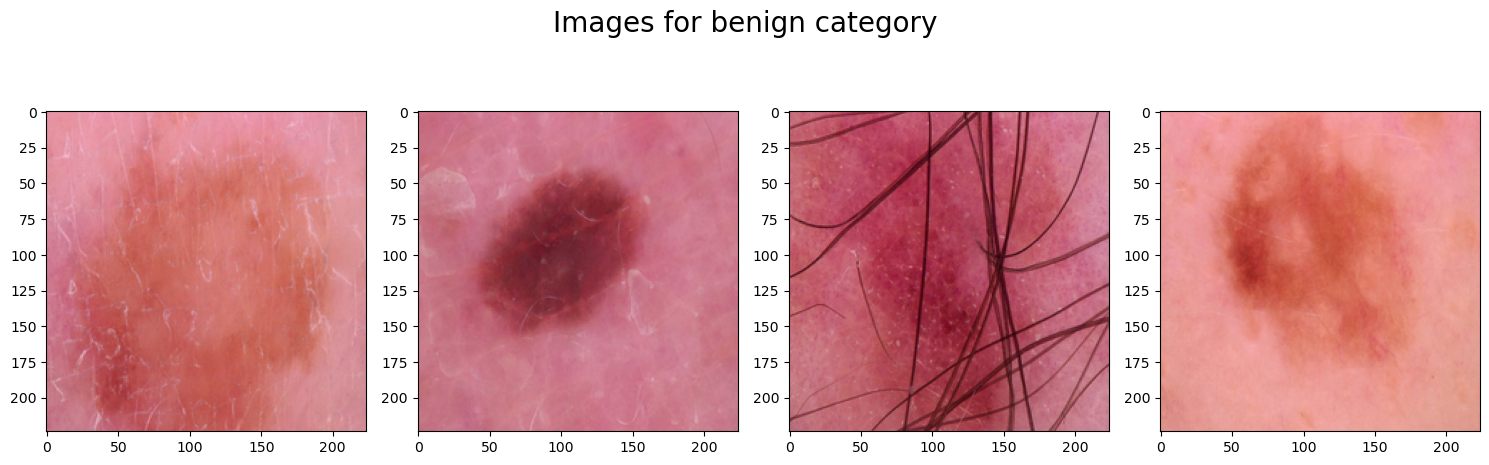

In [61]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [62]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((229,), (41,))

In [63]:
import tensorflow as tf

def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    if label is not None and isinstance(label, str):
        if label == 'benign':
            label = 0
        else:
            label = 1
    else:
        label = None

    return img, label


In [64]:

import tensorflow as tf

def decode_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.resize(img, [224, 224])  
    img = tf.cast(img, tf.float32) / 255.0  
    
    return img, label

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [65]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False


In [66]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [67]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)


In [68]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=7,
					verbose=1)


Epoch 1/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - AUC: 0.5283 - loss: 0.9365 - val_AUC: 0.8111 - val_loss: 2.3690
Epoch 2/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - AUC: 0.8632 - loss: 0.6800 - val_AUC: 0.9000 - val_loss: 0.3923
Epoch 3/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - AUC: 0.9628 - loss: 0.5743 - val_AUC: 0.8528 - val_loss: 1.8182
Epoch 4/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - AUC: 0.9698 - loss: 0.5192 - val_AUC: 0.8972 - val_loss: 0.4372
Epoch 5/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - AUC: 0.9776 - loss: 0.4664 - val_AUC: 0.9056 - val_loss: 0.3824
Epoch 6/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - AUC: 0.9865 - loss: 0.4183 - val_AUC: 0.9139 - val_loss: 0.3178
Epoch 7/7
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - AUC: 0.9924 - loss: 0.3855 - val_AUC: 0.9056 - val_loss: 0.4494


In [74]:

val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - AUC: 0.9056 - loss: 0.4494
Validation Loss: 0.44938209652900696
Validation Accuracy: 0.9055556058883667


In [75]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,AUC,loss,val_AUC,val_loss
0,0.648529,0.861850,0.811111,2.369013
1,0.854314,0.675541,0.900000,0.392252
2,0.963725,0.567662,0.852778,1.818215
3,0.968137,0.520911,0.897222,0.437163
4,0.981373,0.443907,0.905556,0.382371


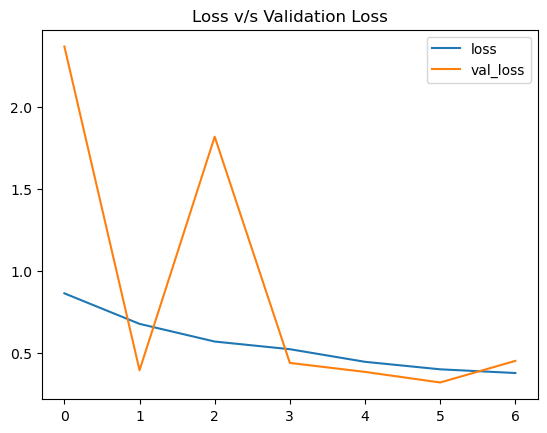

In [70]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


In [72]:
hist_df

,AUC,loss,val_AUC,val_loss
0,0.648529,0.861850,0.811111,2.369013
1,0.854314,0.675541,0.900000,0.392252
2,0.963725,0.567662,0.852778,1.818215
3,0.968137,0.520911,0.897222,0.437163
4,0.981373,0.443907,0.905556,0.382371
5,0.990294,0.398116,0.913889,0.317770
6,0.994314,0.375523,0.905556,0.449382


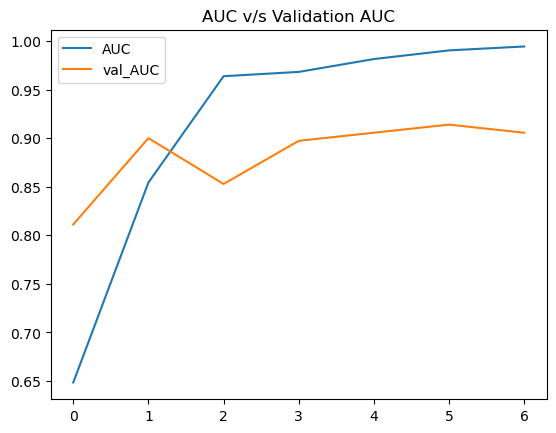

In [73]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()
